In [3]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tifffile import imread
import skimage
from skimage.segmentation import join_segmentations
from skimage.color import rgb2gray

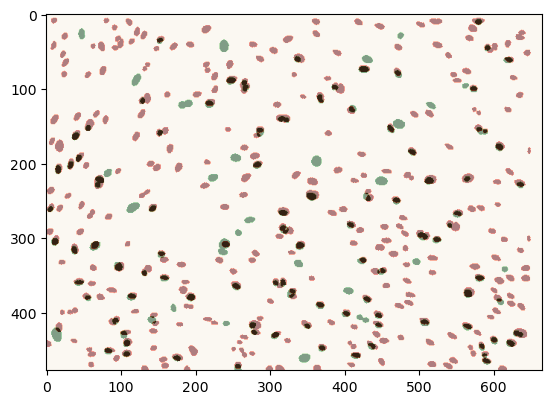

In [4]:
cell_id = 'cellsonlyA1'

fpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/segmentation/{cell_id}.tiff"
img = imread(fpath)

plt.imshow((img[2, 0, :, :] != 0 ), cmap='Reds', alpha=1.0)
plt.imshow((img[3, 0, :, :] != 0), cmap='Greens', alpha=0.5)

## Cell Counting

In [5]:
def count_cells_channel(channel):
    unique_cells = np.unique(channel)
    # Exclude background
    unique_cells = unique_cells[unique_cells != 0]
    return len(unique_cells)

def count_overlap_cells(mappings_1, mappings_2):
    # Sets to track unique overlapping cell IDs
    unique_red_cells = set()
    unique_green_cells = set()
    
    # Loop through unique cells in mappings_1
    for red_cell_id in np.unique(mappings_1):
        if red_cell_id != 0:  # Exclude background
            green_mapped_cells = mappings_2[mappings_1 == red_cell_id]
            # Find the unique green cells that overlap with this red cell
            overlapping_green_cells = np.unique(green_mapped_cells[green_mapped_cells != 0])
            
            if len(overlapping_green_cells) > 0:
                unique_red_cells.add(red_cell_id)
                unique_green_cells.update(overlapping_green_cells)
    
    # Calculate the unique overlap counts for red and green cells
    unique_overlap_count_red = len(unique_red_cells)
    unique_overlap_count_green = len(unique_green_cells)
    
    # If there's a mismatch in the overlap count between red and green, warning
    # if unique_overlap_count_red != unique_overlap_count_green:
        # print(f"Warning: Mismatch in overlap counts! Red: {unique_overlap_count_red}, Green: {unique_overlap_count_green}")
    
    # Return the number of unique overlapping cells (they should be the same)
    return min(unique_overlap_count_red, unique_overlap_count_green)

def count_cells_img(img):
    num_channels, time, height, width = img.shape
    
    time_points = []
    red_counts = []
    green_counts = []
    overlap_counts = []
    
    for t in range(time):
        # Extract red and green channels for time
        red_channel = img[2, t, :, :]
        green_channel = img[3, t, :, :]
        
        # Count cells in red and green
        red_count = count_cells_channel(red_channel)
        green_count = count_cells_channel(green_channel)
        
        # Count overlap
        joined_segmentation, mappings_1, mappings_2 = join_segmentations(
            red_channel.astype(int), green_channel.astype(int), return_mapping=True)
        overlap_count = count_overlap_cells(mappings_1, mappings_2)
        
        time_points.append(t)
        red_counts.append(red_count)
        green_counts.append(green_count)
        overlap_counts.append(overlap_count)
    
    # Create pandas df
    df = pd.DataFrame({
        'Time': time_points,
        'Red Raw': red_counts,
        'Green Raw': green_counts,
        'Both': overlap_counts # not right
    })
    
    df["Red Only"] = df["Red Raw"] - df["Both"]
    df["Green Only"] = df["Green Raw"] - df["Both"]
    
    return df

result = count_cells_img(img)
print(result.head())

   Time  Red Raw  Green Raw  Both  Red Only  Green Only
0     0      339        129   101       238          28
1     1      341        123    97       244          26
2     2      364        116    93       271          23
3     3      360        109    87       273          22
4     4      359        116    95       264          21


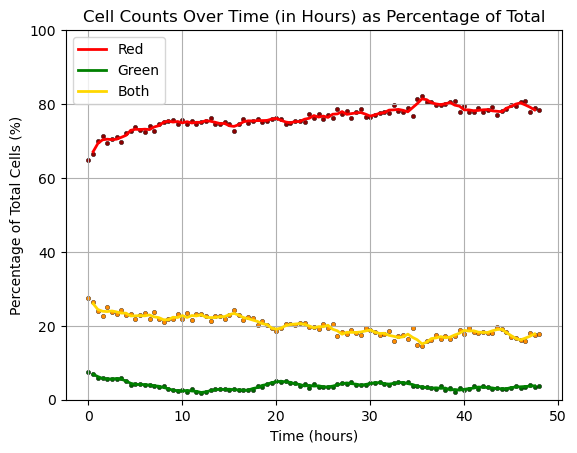

In [6]:
def plot_result_overlap(result):
    # Calculate total cells and percentages
    result['Total'] = result['Red Only'] + result['Green Only'] + result['Both']
    result['Red Only (%)'] = (result['Red Only'] / result['Total']) * 100
    result['Green Only (%)'] = (result['Green Only'] / result['Total']) * 100
    result['Both (%)'] = (result['Both'] / result['Total']) * 100
    result['Hour'] = result['Time'] / 2

    # Define a rolling window size, e.g., 3
    window_size = 3

    # Calculate the rolling averages
    result['Red Only (Rolling %)'] = result['Red Only (%)'].rolling(window=window_size, center=True).mean()
    result['Green Only (Rolling %)'] = result['Green Only (%)'].rolling(window=window_size, center=True).mean()
    result['Both (Rolling %)'] = result['Both (%)'].rolling(window=window_size, center=True).mean()

    # Plot
    plt.figure()

    # Plot the smoothed lines (rolling average)
    sns.lineplot(x='Hour', y='Red Only (Rolling %)', data=result, label='Red', color='red', lw=2)
    sns.lineplot(x='Hour', y='Green Only (Rolling %)', data=result, label='Green', color='green', lw=2)
    sns.lineplot(x='Hour', y='Both (Rolling %)', data=result, label='Both', color='gold', lw=2)

    # Plot individual points on top of the smoothed lines
    sns.scatterplot(x='Hour', y='Red Only (%)', data=result, color='darkred', s=10, edgecolor='black')
    sns.scatterplot(x='Hour', y='Green Only (%)', data=result, color='#006400', s=10, edgecolor='black')
    sns.scatterplot(x='Hour', y='Both (%)', data=result, color='darkorange', s=10, edgecolor='black')

    # Update the plot titles and labels accordingly
    plt.title('Cell Counts Over Time (in Hours) as Percentage of Total')
    plt.xlabel('Time (hours)')
    plt.ylabel('Percentage of Total Cells (%)')
    plt.ylim(0, 100)
    plt.grid(True)

    plt.legend()

    plt.show()


plot_result_overlap(result)

## Stats

In [7]:
from scipy.stats import chi2_contingency

def test_proportion_constancy(df):
    # Perform a chi-squared test to check if green remains constant across time points
    observed = df[['Green Only', 'Red Only', 'Both']].values
    chi2, p_value, _, _ = chi2_contingency(observed, correction=False)
    return p_value

def analyze_results(df):
    analysis = []
    
    for file_name, df in df:
        p_value = test_proportion_constancy(df)
        # True = signficant difference, False = no significant difference
        analysis.append({'File': file_name, 'P-Value': p_value, 'Significant': p_value < 0.05})
        
    analysis_df = pd.DataFrame(analysis)
    
    return analysis_df

In [8]:
fpath = "/scratch/indikar_root/indikar1/shared_data/apollo/segmentation"

file_list = glob.glob(os.path.join(fpath, "*"))

results = []

for file in file_list:
    img = imread(file)
    df = count_cells_img(img)
    file_name = os.path.splitext(os.path.basename(file))[0]
    results.append((file_name, df))

analysis_results = analyze_results(results)
analysis_results = analysis_results.sort_values('File')

In [9]:
print(analysis_results)

                File        P-Value  Significant
9        cellsonlyA1   2.604209e-07         True
3        cellsonlyB1   5.800704e-03         True
19       cellsonlyC1   8.117253e-02        False
0        cellsonlyD1   3.045138e-01        False
17       mmRNA4OHTA3  8.140541e-203         True
6        mmRNA4OHTB3  4.539742e-166         True
14       mmRNA4OHTC3   4.846016e-74         True
7        mmRNA4OHTD3   1.951601e-54         True
8   mmRNA4OHTsiRNAA4   2.952329e-25         True
15  mmRNA4OHTsiRNAB4   2.765392e-03         True
5   mmRNA4OHTsiRNAC4   4.417744e-65         True
12  mmRNA4OHTsiRNAD4  9.671615e-100         True
1        mmRNAonlyA2  4.831141e-231         True
10       mmRNAonlyB2  2.858421e-111         True
11       mmRNAonlyC2   1.153797e-52         True
18       mmRNAonlyD2  3.216437e-155         True
4        siRNAonlyA5  8.060989e-143         True
2        siRNAonlyB5   8.930402e-51         True
13       siRNAonlyC5   1.588331e-79         True
16       siRNAonlyD5

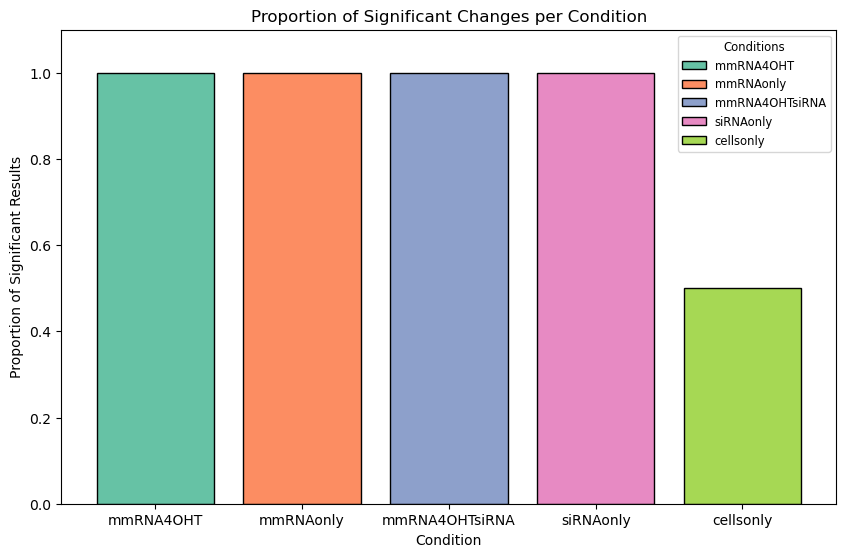

In [10]:
def plot_analysis(analysis_df):
    conditions = ['mmRNA4OHTsiRNA', 'mmRNA4OHT', 'mmRNAonly', 'siRNAonly', 'cellsonly']

    # Create a new column 'Condition' based on the prefix matching one of the conditions
    analysis_df['Condition'] = analysis_df['File'].apply(lambda x: next((cond for cond in conditions if x.startswith(cond)), 'Unknown'))

    # Calculate proportion of significant results per condition
    condition_analysis = analysis_df.groupby('Condition')['Significant'].mean().reset_index()
    condition_analysis.columns = ['Condition', 'Proportion_Significant']
    condition_analysis = condition_analysis.sort_values(by='Proportion_Significant', ascending=False)

    # Plot proportion of significant results (bar plot)
    plt.figure(figsize=(10, 6))

    # Custom color palette with associated conditions
    colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
    bars = plt.bar(condition_analysis['Condition'], 
                   condition_analysis['Proportion_Significant'], 
                   color=colors, 
                   edgecolor='black')  # Add edge to the bars

    # Create a manual legend
    plt.legend(bars, condition_analysis['Condition'], title="Conditions", loc="upper right", fontsize='small', title_fontsize='small')

    plt.xlabel('Condition')
    plt.ylabel('Proportion of Significant Results')
    plt.title('Proportion of Significant Changes per Condition')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=0)  # Set labels to horizontal
    plt.subplots_adjust(top=0.9)  # Add margin at the top
    plt.show()

plot_analysis(analysis_results)

In [30]:
def test_proportion_constancy(df):
    # Perform a chi-squared test across the whole dataset (all time points)
    observed = df[['Green Only', 'Red Only', 'Both']].values
    chi2, p_value, _, _ = chi2_contingency(observed, correction=False)
    return p_value

def test_proportion_per_timepoint(df):
    significant_timepoints = []
    
    # Calculate the overall expected proportions (e.g., the global average)
    total_counts = df[['Red Only', 'Green Only', 'Both']].sum(axis=0)
    expected_proportions = total_counts / total_counts.sum()  # Normalize to get proportions
    
    for time in df['Time'].unique():
        # Get the observed counts for the current time point
        observed_counts = df[df['Time'] == time][['Red Only', 'Green Only', 'Both']].values[0]
        
        # Scale expected proportions by the total number of observed cells at this time point
        expected_counts = expected_proportions * observed_counts.sum()
        
        # Perform chi-squared test comparing observed vs expected counts
        chi2, p_value, _, _ = chi2_contingency([observed_counts, expected_counts])
        
        # Print the p-value for debugging purposes
        # print(f"Time: {time}, P-value: {p_value}")
        
        # If the p-value is less than 0.05, it indicates a significant difference
        if p_value < 0.05:
            significant_timepoints.append(time)
    
    return significant_timepoints

def analyze_results(results):
    analysis = []
    significant_timepoints_all_files = []  # List to store significant timepoints for each file
    
    for file_name, df in results:
        p_value = test_proportion_constancy(df)
        significant_timepoints = test_proportion_per_timepoint(df)
        
        # Iterate through each row (time point) and store relevant information
        for i, row in df.iterrows():
            analysis_dict = {
                'File': file_name,
                'Time': row['Time'],
                'Red Only': row['Red Only'],
                'Green Only': row['Green Only'],
                'Both': row['Both'],
                'P-Value': p_value,
                'Significant': p_value < 0.05
            }
            
            # Append each row's analysis to the list
            analysis.append(analysis_dict)
        
        # Append the significant timepoints for this file
        significant_timepoints_all_files.append({'File': file_name, 'Significant Timepoints': significant_timepoints})
    
    # Convert the list of dictionaries to a DataFrame
    analysis_df = pd.DataFrame(analysis)
    
    # Convert significant timepoints into a DataFrame
    significant_timepoints_df = pd.DataFrame(significant_timepoints_all_files)
    
    return analysis_df, significant_timepoints_df

# Example: Call the function
timepoint_results, significant_timepoints_df = analyze_results(results)
significant_timepoints_df = significant_timepoints_df.sort_values('File')
print(significant_timepoints_df)

                File                             Significant Timepoints
9        cellsonlyA1                                             [0, 1]
3        cellsonlyB1                                                 []
19       cellsonlyC1                                             [1, 4]
0        cellsonlyD1                                               [94]
17       mmRNA4OHTA3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
6        mmRNA4OHTB3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
14       mmRNA4OHTC3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
7        mmRNA4OHTD3                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
8   mmRNA4OHTsiRNAA4         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
15  mmRNA4OHTsiRNAB4                                                 []
5   mmRNA4OHTsiRNAC4                        [0, 1, 2, 3, 4, 5, 6, 7, 8]
12  mmRNA4OHTsiRNAD4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...
1        mmRNAonlyA2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,

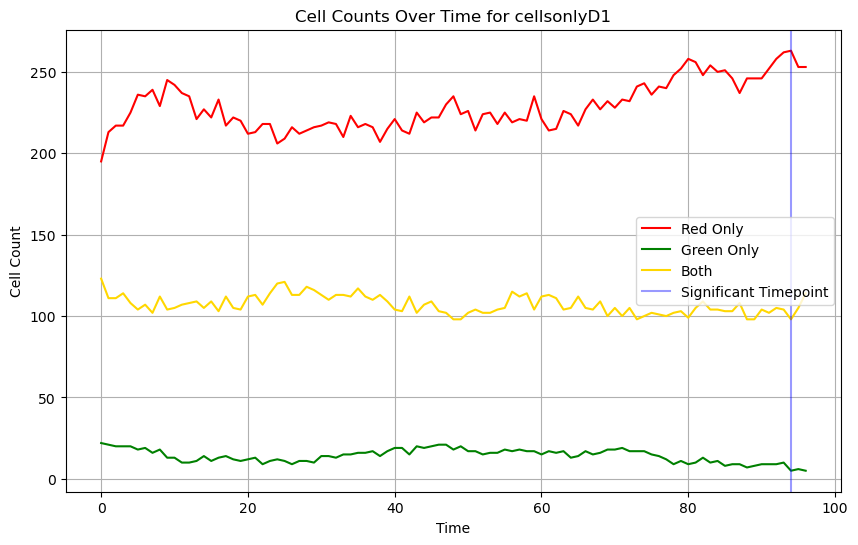

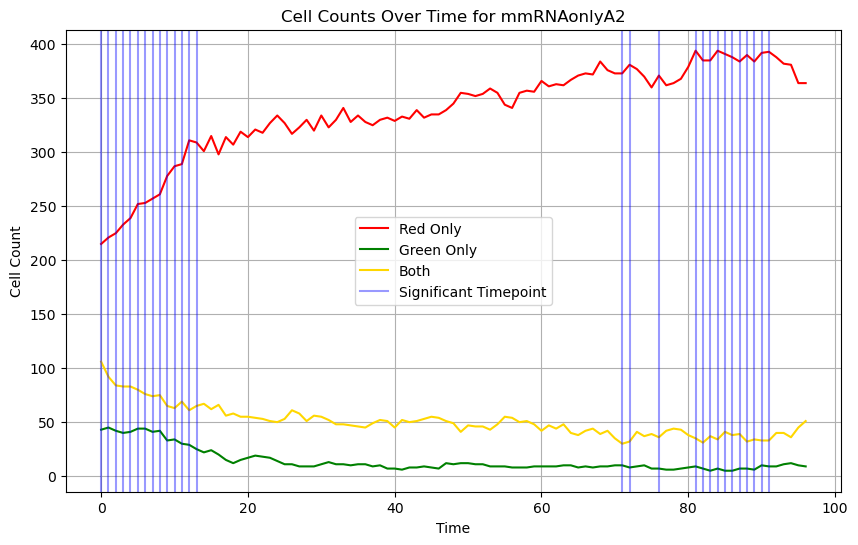

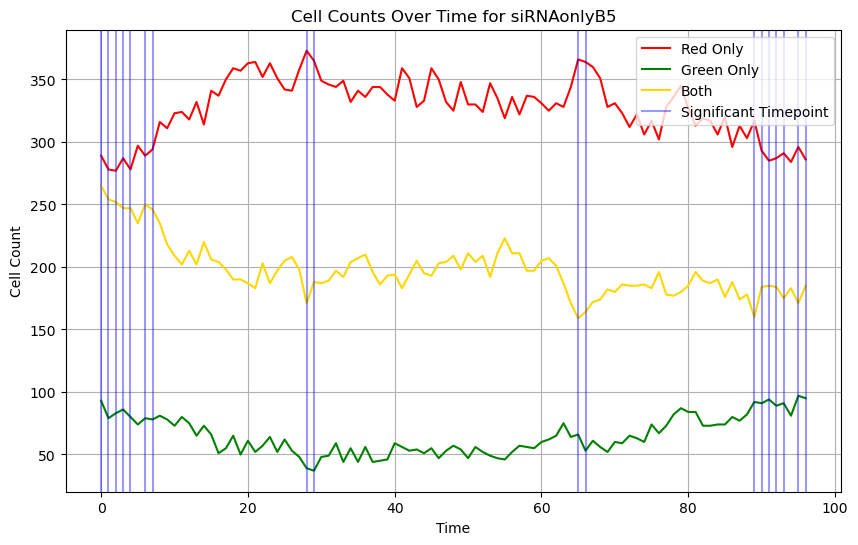

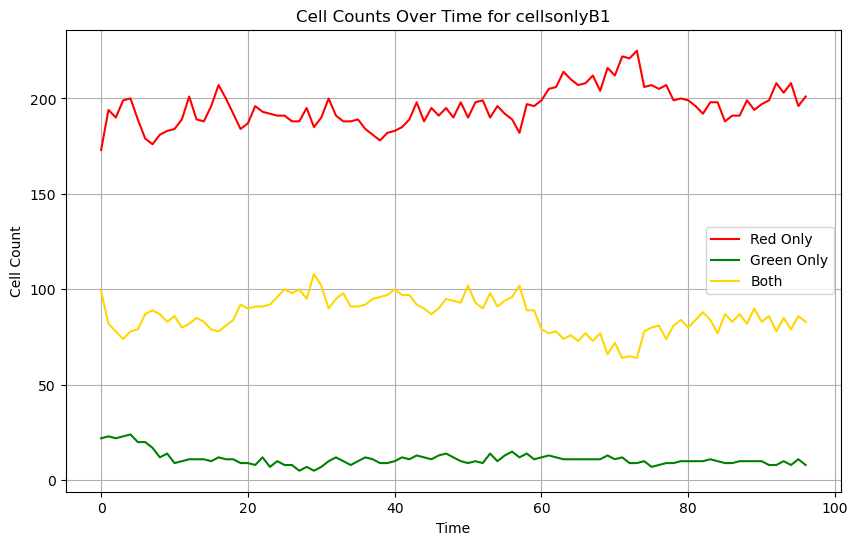

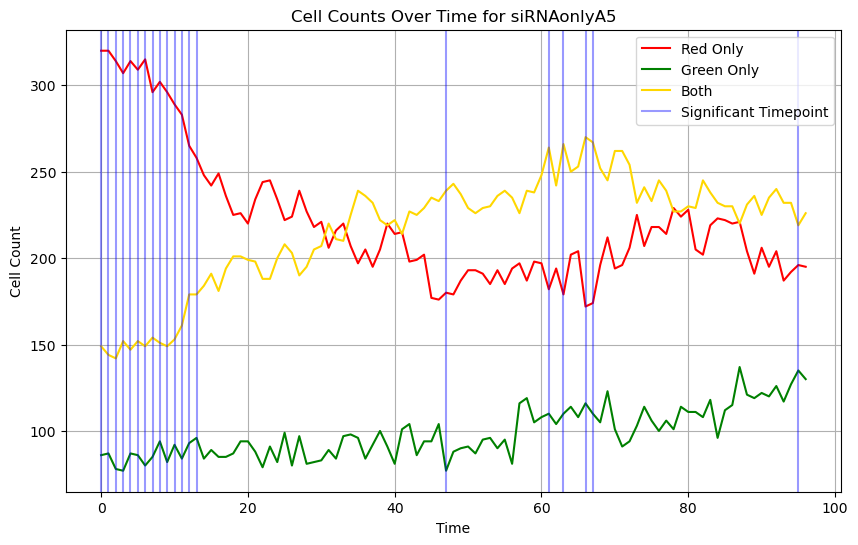

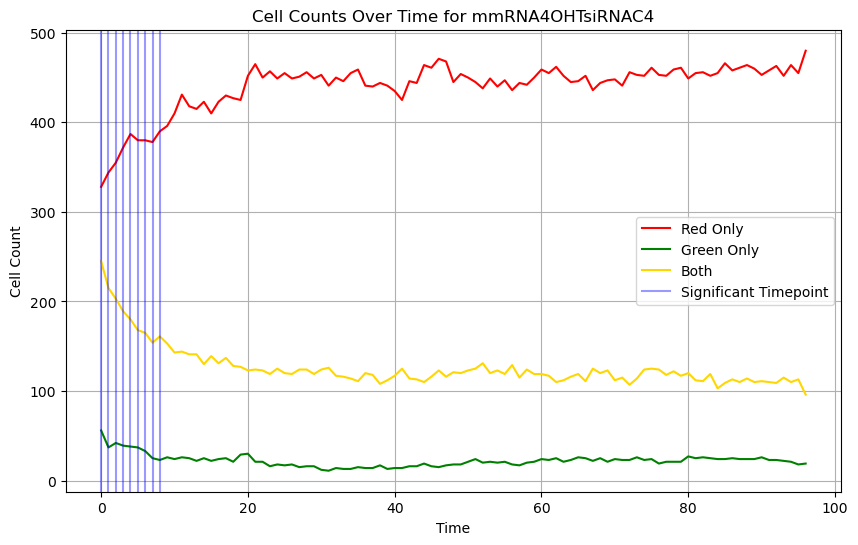

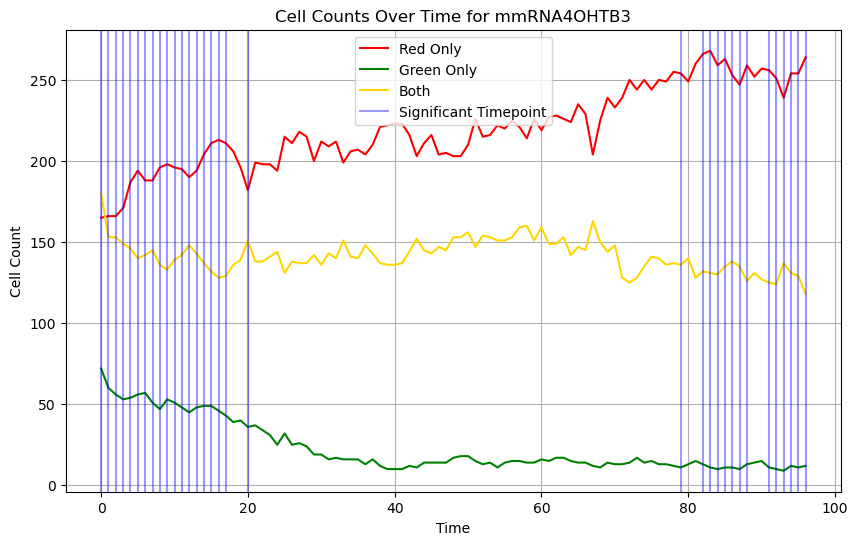

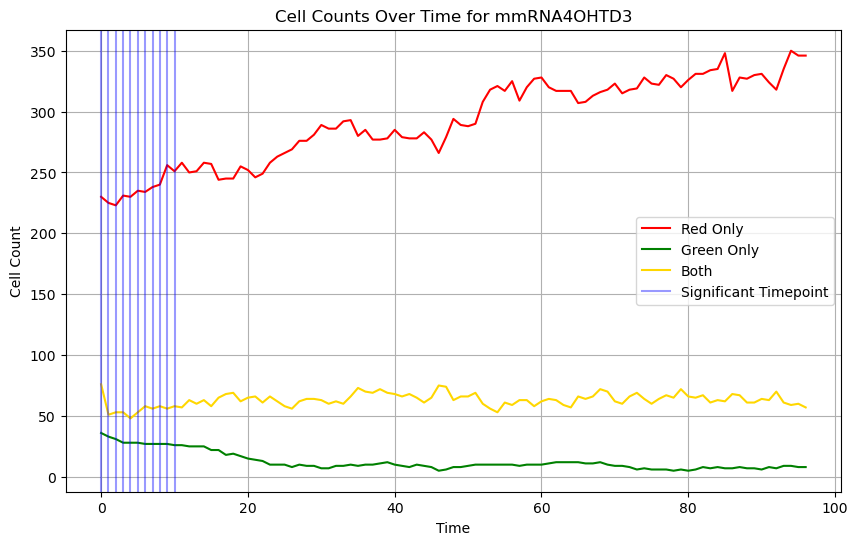

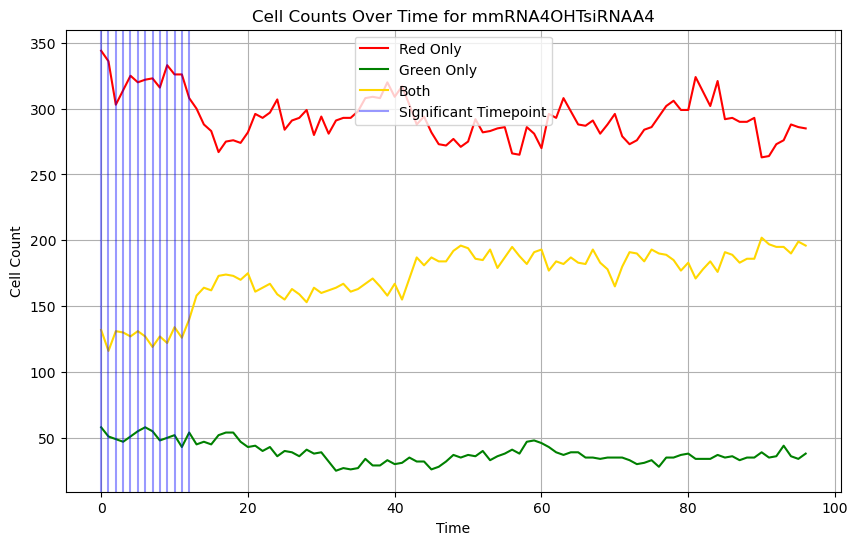

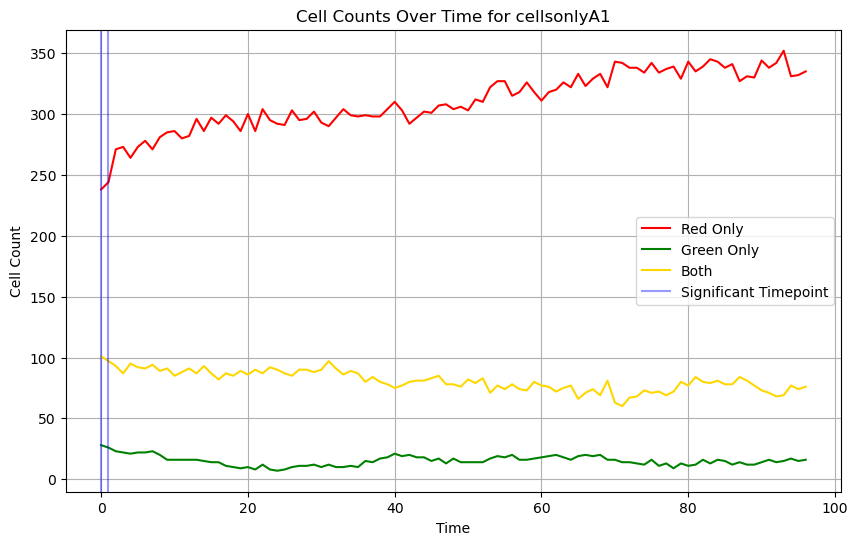

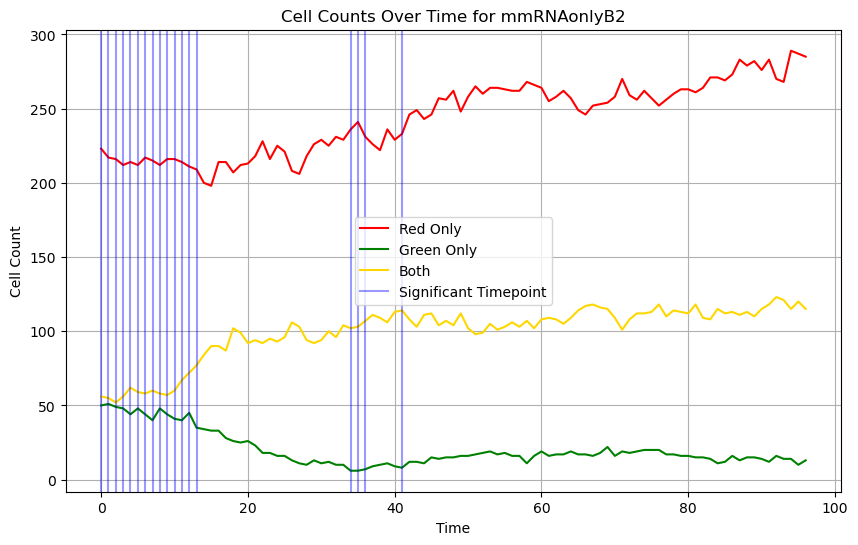

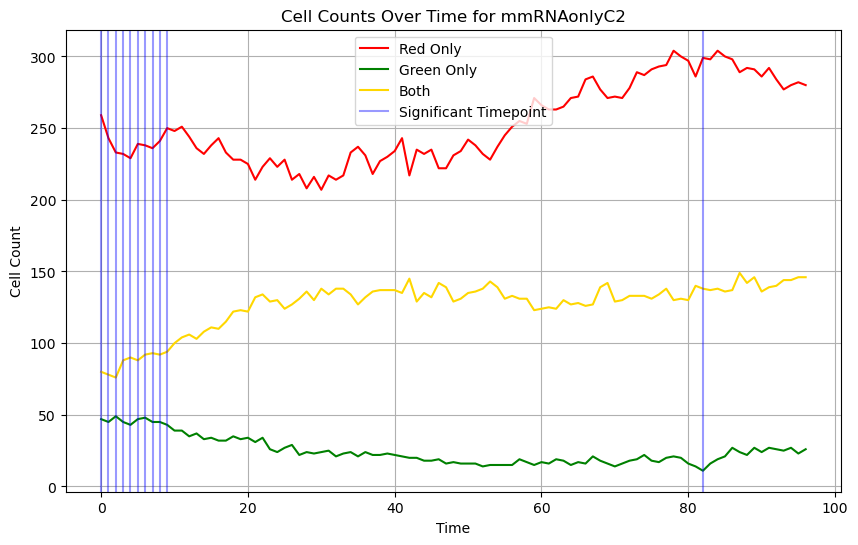

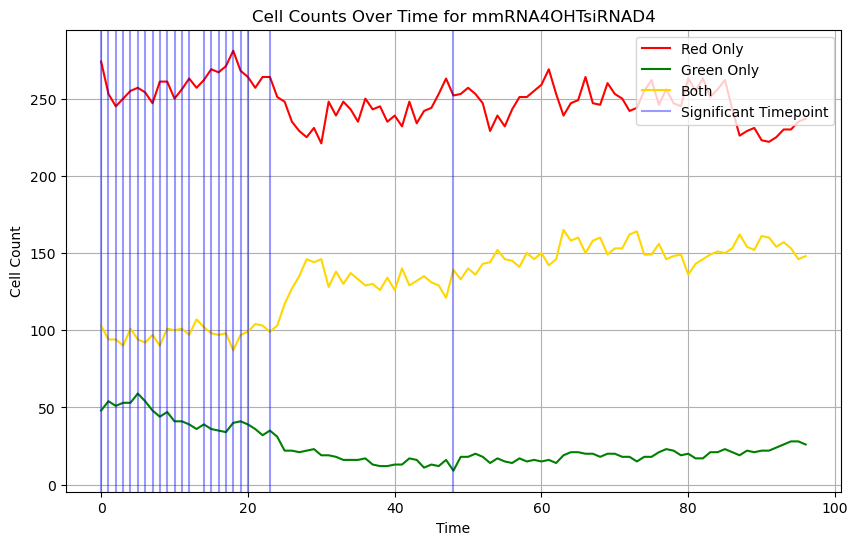

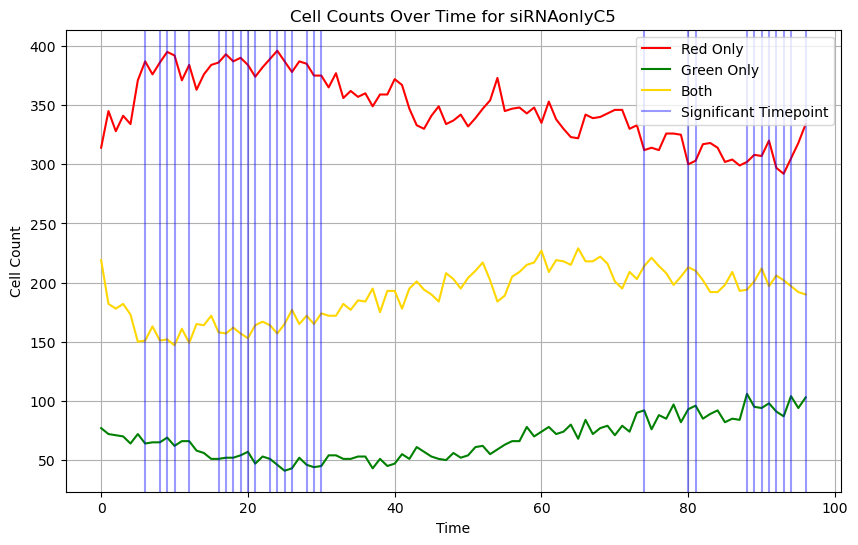

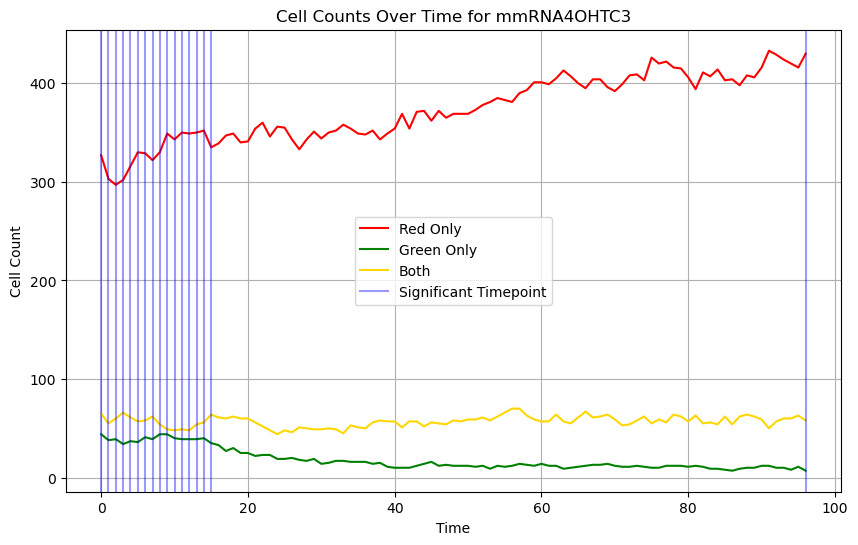

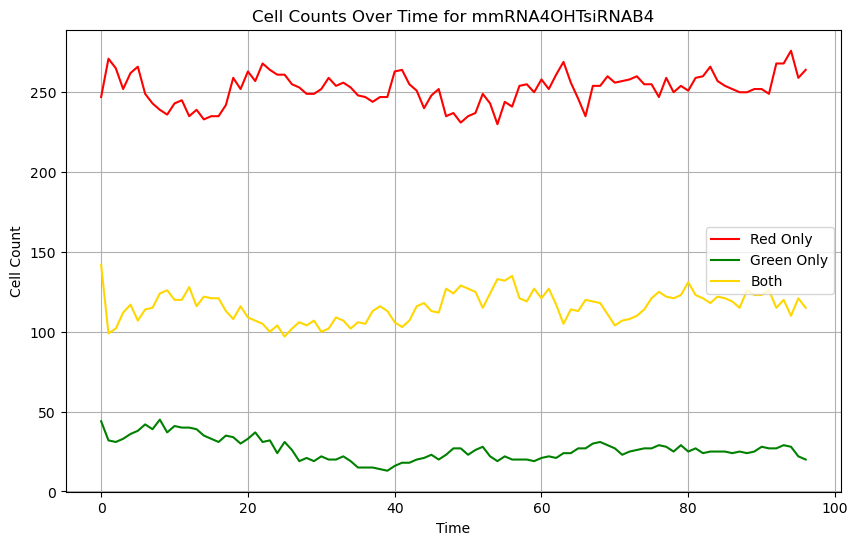

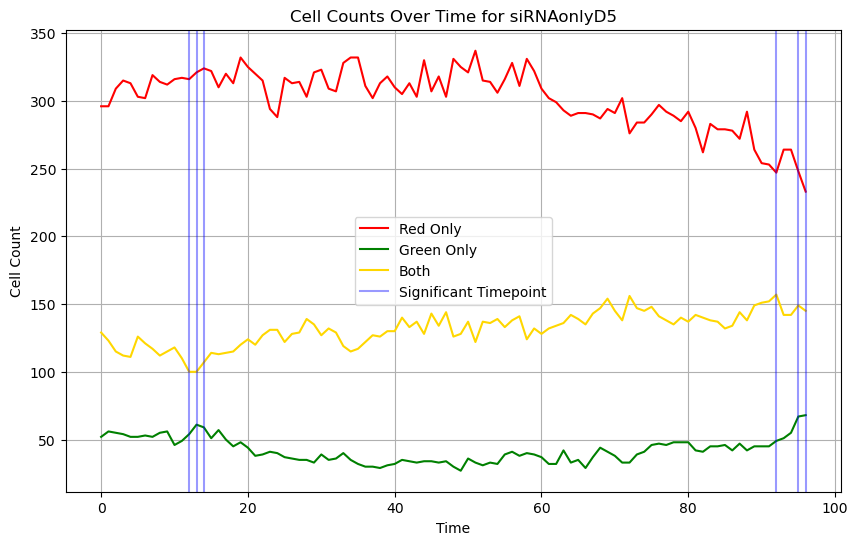

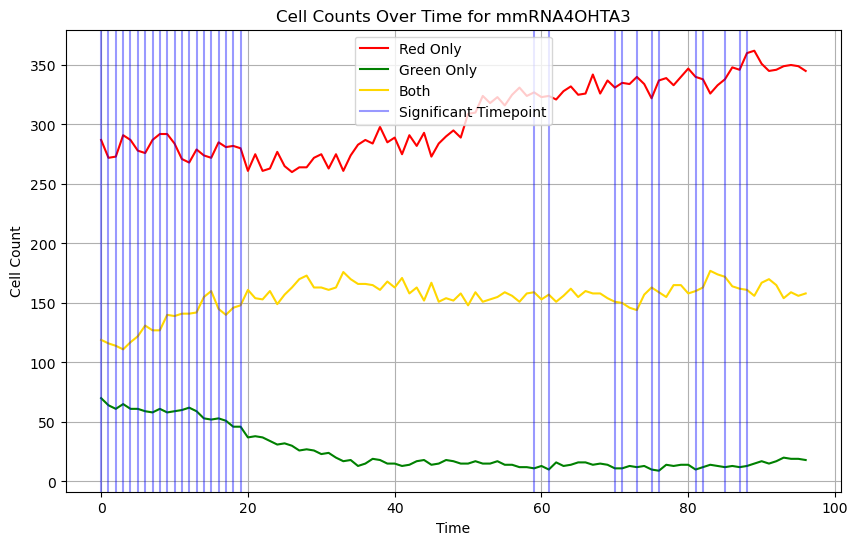

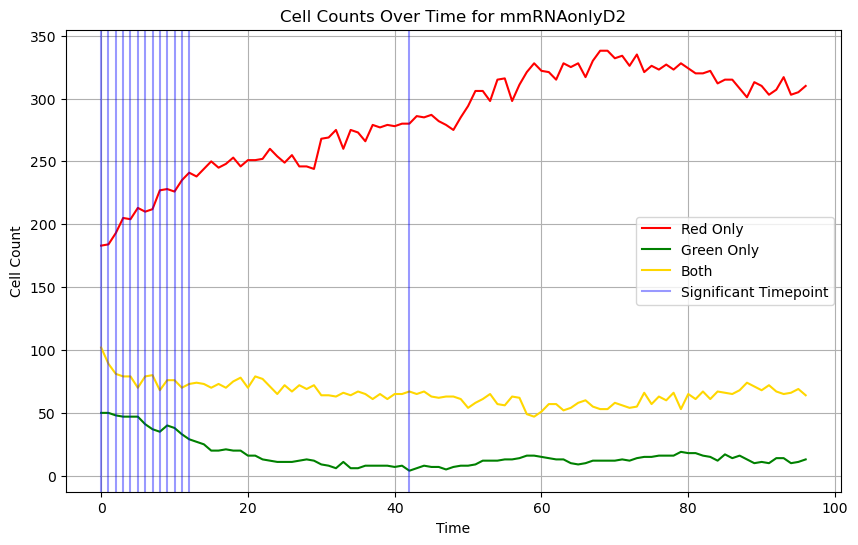

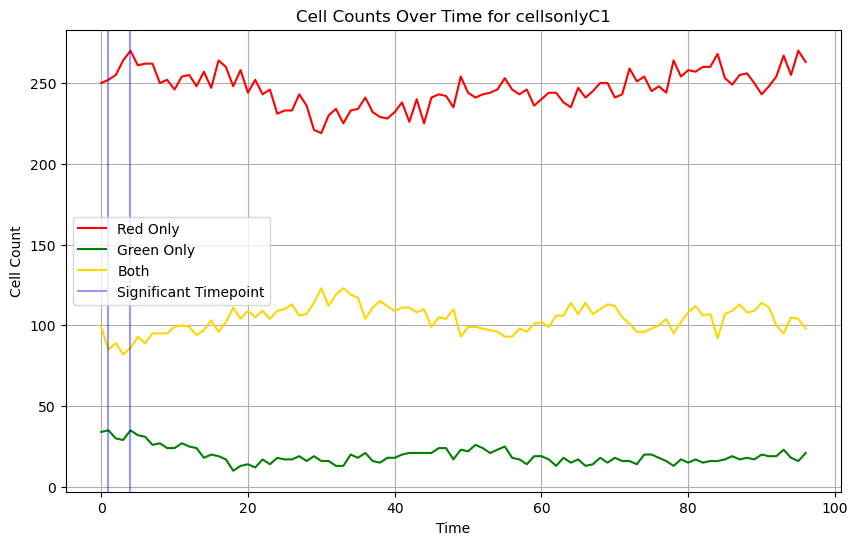

In [32]:
def plot_results(results, significant_timepoints_df):
    # Loop through each file in the results
    for file_name, df in results:
        # Filter significant timepoints for this file
        significant_times = significant_timepoints_df[significant_timepoints_df['File'] == file_name]['Significant Timepoints'].values[0]

        # Create the plot
        plt.figure(figsize=(10, 6))
        
        # Plot Red Only, Green Only, Both over time
        sns.lineplot(x='Time', y='Red Only', data=df, label='Red Only', color='red')
        sns.lineplot(x='Time', y='Green Only', data=df, label='Green Only', color='green')
        sns.lineplot(x='Time', y='Both', data=df, label='Both', color='gold')

        # Mark significant time points
        if significant_times:  # Check if significant timepoints exist
            for sig_time in significant_times:
                plt.axvline(x=sig_time, color='blue', alpha=0.4, label='Significant Timepoint' if sig_time == significant_times[0] else "")

        # Add titles and labels
        plt.title(f'Cell Counts Over Time for {file_name}')
        plt.xlabel('Time')
        plt.ylabel('Cell Count')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()

plot_results(results, significant_timepoints_df)